In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import zipfile
import io
import os
import sys
import json
import geopandas as gpd
from gridstatus import EIA
from us import states
import census
from dotenv import load_dotenv

load_dotenv("../../.env")

True

# Extract data from EIA

In [2]:
eia = EIA()

In [3]:
eia.list_routes("electricity")

{'id': 'electricity',
 'name': 'Electricity',
 'description': 'EIA electricity survey data',
 'routes': [{'id': 'retail-sales',
   'name': 'Electricity Sales to Ultimate Customers',
   'description': 'Electricity sales to ultimate customer by state and sector (number of customers, average price, revenue, and megawatthours of sales).  \n    Sources: Forms EIA-826, EIA-861, EIA-861M'},
  {'id': 'electric-power-operational-data',
   'name': 'Electric Power Operations (Annual and Monthly)',
   'description': 'Monthly and annual electric power operations by state, sector, and energy source.\n    Source: Form EIA-923'},
  {'id': 'rto',
   'name': 'Electric Power Operations (Daily and Hourly)',
   'description': 'Hourly and daily electric power operations by balancing authority.  \n    Source: Form EIA-930'},
  {'id': 'state-electricity-profiles',
   'name': 'State Specific Data',
   'description': 'State Specific Data'},
  {'id': 'operating-generator-capacity',
   'name': 'Inventory of Opera

In [4]:
routes = eia.list_routes("electricity/operating-generator-capacity")

In [5]:
routes['data']

{'nameplate-capacity-mw': {'alias': 'Nameplate Capacity', 'units': 'MW'},
 'net-summer-capacity-mw': {'alias': 'Net Summer Capacity', 'units': 'MW'},
 'net-winter-capacity-mw': {'alias': 'Net Winter Capacity', 'units': 'MW'},
 'operating-year-month': {'alias': 'Operating Date (Year and Month)'},
 'planned-retirement-year-month': {'alias': 'Planned Retirement Date (Year and Month)'},
 'planned-derate-year-month': {'alias': 'Planned Derate Date (Year and Month)'},
 'planned-derate-summer-cap-mw': {'alias': 'Magnitude of Planned Derate (Summer Capacity)',
  'units': 'MW'},
 'planned-uprate-year-month': {'alias': 'Planned Uprate Date (Year and Month)'},
 'planned-uprate-summer-cap-mw': {'alias': 'Magnitude of Planned Uprate (Summer Capacity)',
  'units': 'MW'},
 'county': {'alias': 'County'},
 'longitude': {'alias': 'Longitude'},
 'latitude': {'alias': 'Latitude'}}

In [6]:
facet_list = eia.list_facets("electricity/operating-generator-capacity")

In [7]:
facet_list.keys()

dict_keys(['stateid', 'sector', 'entityid', 'plantid', 'generatorid', 'unit', 'technology', 'energy_source_code', 'prime_mover_code', 'balancing_authority_code', 'status'])

In [8]:
BASE_URL = "https://api.eia.gov/v2/"

In [9]:
dataset = "electricity/operating-generator-capacity"
route = dataset + "/data"

In [10]:
DATASET_CONFIG = {
    "electricity/operating-generator-capacity": {
        "index": [
            "period",
            "balancing_authority_code",
            "stateid",
            "plantid",
            # "balancing_authority_code",
        ],
        # "handler": _handle_rto_interchange,
    },
}


In [11]:
start_str = "2024-01"
end_str = "2024-04"
frequency= 'monthly'
facets = {'balancing_authority_code':['SWPP'],
          'stateid':['KS','MO']}

params = {
            "start": start_str,
            "end": end_str,
            "frequency": frequency,
            "facets": facets,
            "offset": 0,
            "length": 5000,
            "data":["county", 
                    "longitude",
                    "latitude",
                    "nameplate-capacity-mw",
                    "operating-year-month",
                    "planned-retirement-year-month"],
            # pagination breaks if not sorted because
            # api doesn't return in stable order across requests
            "sort": [
                {"column": col, "direction": "asc"}
                for col in DATASET_CONFIG[dataset]["index"]
            ],
        }
headers = {
            "X-Api-Key": eia.api_key,
            "X-Params": json.dumps(params),
        }

In [12]:
r = requests.get(BASE_URL+route, headers=headers)
r

<Response [200]>

In [13]:
response = r.json()['response']
data = response['data']

In [14]:
df = pd.DataFrame(data)

In [15]:
locations = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='EPSG:4326')

In [16]:
gdf = gpd.GeoDataFrame(df, geometry=locations)

In [17]:
gdf = gdf.set_index(['stateid','county','plantid','entityName'])

gdf.replace([ 'Natural Gas Fired Combustion Turbine',
              'Natural Gas Steam Turbine',
              'Natural Gas Fired Combined Cycle',
              'Natural Gas Internal Combustion Engine', 
              'Landfill Gas'], 
            "Natural Gas",
            inplace=True)

gdf.replace({'Conventional Hydroelectric':'Hydro',
             'Onshore Wind Turbine':'Wind Turbine',
             'Conventional Steam Coal':'Coal',
             'Petroleum Liquids':'Petroleum',
             'Solar Photovoltaic':'Solar PV',
             },
            inplace=True)

gdf['nameplate-capacity-mw'] = gdf['nameplate-capacity-mw'].astype('float')

In [18]:
gdf_pivoted = gdf.pivot_table(index='stateName',
                columns='technology',
                values='nameplate-capacity-mw',
                aggfunc='sum')

## Get shape files for Missouri and Kansas

In [19]:
ks_url = states.KS.shapefile_urls()['county']
mo_url = states.MO.shapefile_urls()['county']
ks = gpd.read_file(ks_url)
mo = gpd.read_file(mo_url)

In [20]:
color = {'Coal':'saddlebrown',
         'Batteries':'tab:pink',
         'Solar PV':'gold',
         'Petroleum':'k',
         'Hydro':'cyan',
         'Wind Turbine':'lime',
         'Nuclear':'tab:green',
         'Natural Gas':'tab:orange',
         'All Other':'darkred'}

In [21]:
color_list = [color[tech] for tech in gdf['technology']]

In [22]:
wyandotte = ks[ks['NAME10']=='Wyandotte']

In [23]:
wyandotte.to_crs(epsg=6922).centroid.buffer(50*1600).to_crs(epsg=4269).to_frame()

,0
20,"POLYGON ((-93.84042 39.08375, -93.84920 39.013..."


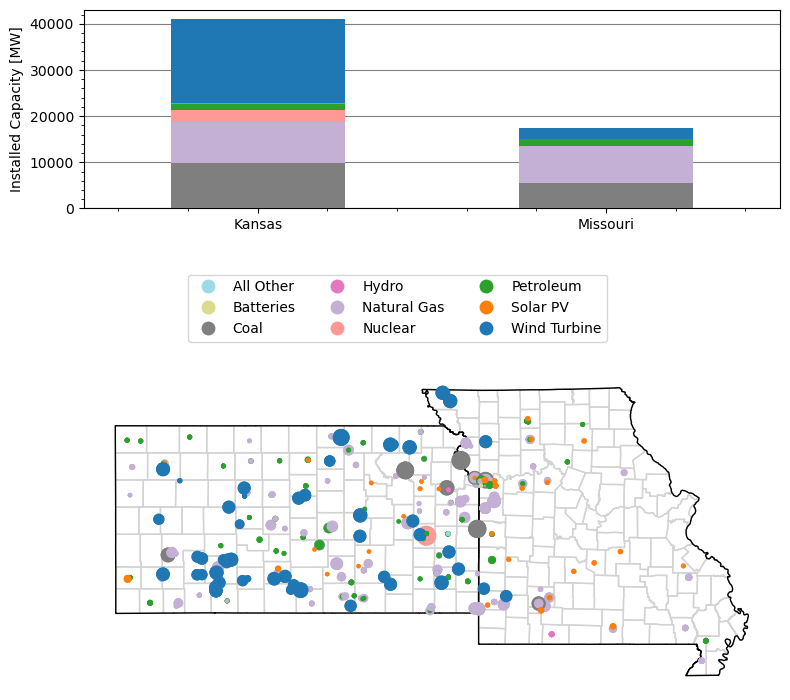

In [24]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8), 
                       height_ratios=[1,2.5]
                       )
color_map = 'tab20_r'
ks.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
mo.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
ks.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
mo.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
gdf.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )

gdf_pivoted.plot(ax=ax[0], kind='bar', 
                 stacked=True, 
                 cmap=color_map,
                 legend=False,
                 zorder=3)

ax[0].set_xlabel('')
ax[0].tick_params(axis='x',rotation=0)
ax[0].set_ylabel("Installed Capacity [MW]")
ax[1].set_axis_off()
ax[0].minorticks_on()
ax[0].yaxis.grid(which='major',linestyle='-', alpha=0.5, color='k',zorder=0)

plt.tight_layout()

## Within 50 miles of Wyandotte County, Kansas

The CRS EPSG:6922 is measured in units of meters.

In [25]:
from unyt import mile, meter

buffer_distance = (50*mile).to(meter).to_value()

In [26]:
buffered_plants = gpd.sjoin(gdf.to_crs(epsg=6922),
                            wyandotte.to_crs(epsg=6922)
                                     .centroid.buffer(buffer_distance)
                                     .to_frame(), how='inner')\
                            .to_crs(epsg=4269)

In [27]:
buffered_plants_pivot = buffered_plants.pivot_table(index='stateName',
                columns='technology',
                values='nameplate-capacity-mw',
                aggfunc='sum')

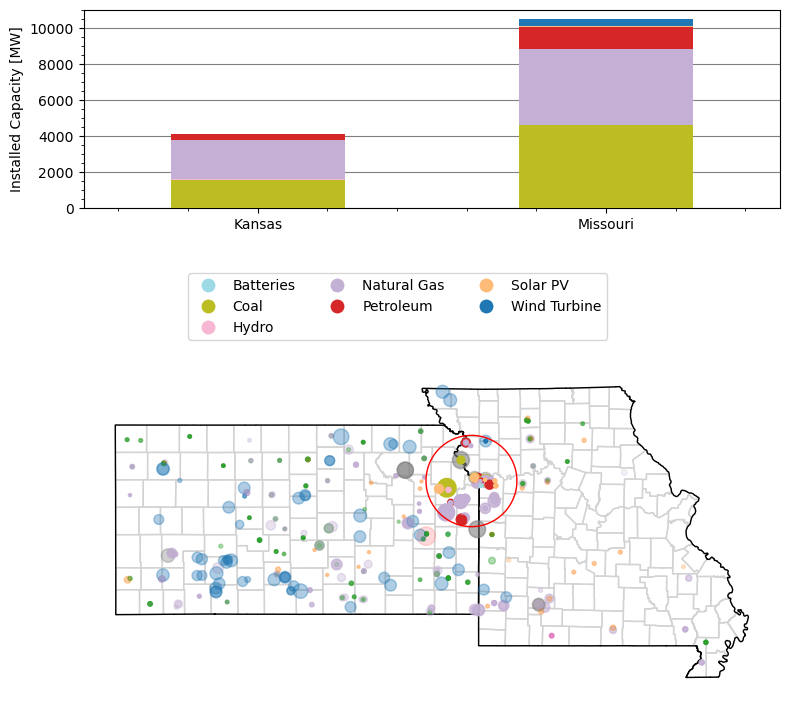

In [28]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8), 
                       height_ratios=[1,2.5]
                       )
color_map = 'tab20_r'
ks.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
mo.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
ks.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
mo.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
gdf.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           alpha=0.2,
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )

buffered_plants.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )
# get a buffer zone around Wyandotte County, KS
wyandotte.to_crs(epsg=6922).centroid.buffer(buffer_distance).to_crs(epsg=4269).plot(ax=ax[1], facecolor='None', edgecolor='r')


buffered_plants_pivot.plot(ax=ax[0], kind='bar', 
                 stacked=True, 
                 cmap=color_map,
                 legend=False,
                 zorder=3)

ax[0].set_xlabel('')
ax[0].tick_params(axis='x',rotation=0)
ax[0].set_ylabel("Installed Capacity [MW]")
ax[1].set_axis_off()
ax[0].minorticks_on()
ax[0].yaxis.grid(which='major',linestyle='-', alpha=0.5, color='k',zorder=0)

plt.tight_layout()

# Within Kansas City itself

In [29]:
states.KS.shapefile_urls()

{'tract': 'https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_20_tract10.zip',
 'cd': 'https://www2.census.gov/geo/tiger/TIGER2010/CD/111/tl_2010_20_cd111.zip',
 'county': 'https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2010/tl_2010_20_county10.zip',
 'state': 'https://www2.census.gov/geo/tiger/TIGER2010/STATE/2010/tl_2010_20_state10.zip',
 'zcta': 'https://www2.census.gov/geo/tiger/TIGER2010/ZCTA5/2010/tl_2010_20_zcta510.zip',
 'block': 'https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_20_tabblock10.zip',
 'blockgroup': 'https://www2.census.gov/geo/tiger/TIGER2010/BG/2010/tl_2010_20_bg10.zip'}

In [30]:
ks_url = states.KS.shapefile_urls()['tract']
mo_url = states.MO.shapefile_urls()['tract']
ks_tract = gpd.read_file(ks_url)
mo_tract = gpd.read_file(mo_url)

In [31]:
us_cities = gpd.read_file("https://data.cdc.gov/download/n44h-hy2j/application%2Fzip")

In [32]:
us_cities.set_index(['CLASS','ST','NAME'], inplace=True)

In [33]:
kc_ksmo = us_cities.xs((slice(None), slice(None), 'Kansas City'))

In [34]:
kc_plants = gpd.sjoin( gdf, kc_ksmo.to_crs(epsg=4326), how='inner')

<Axes: >

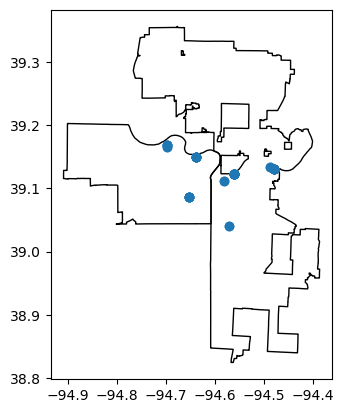

In [35]:
fig, ax = plt.subplots()
kc_ksmo.to_crs(epsg=4326).plot(ax=ax, facecolor='None', edgecolor='k')
kc_plants.plot(ax=ax)

In [36]:
kc_plants_pivot = kc_plants.pivot_table(index='stateName',
                columns='technology',
                values='nameplate-capacity-mw',
                aggfunc='sum')

In [37]:
kc_outline = gpd.GeoDataFrame(geometry=[kc_ksmo.unary_union], crs='epsg:3857')

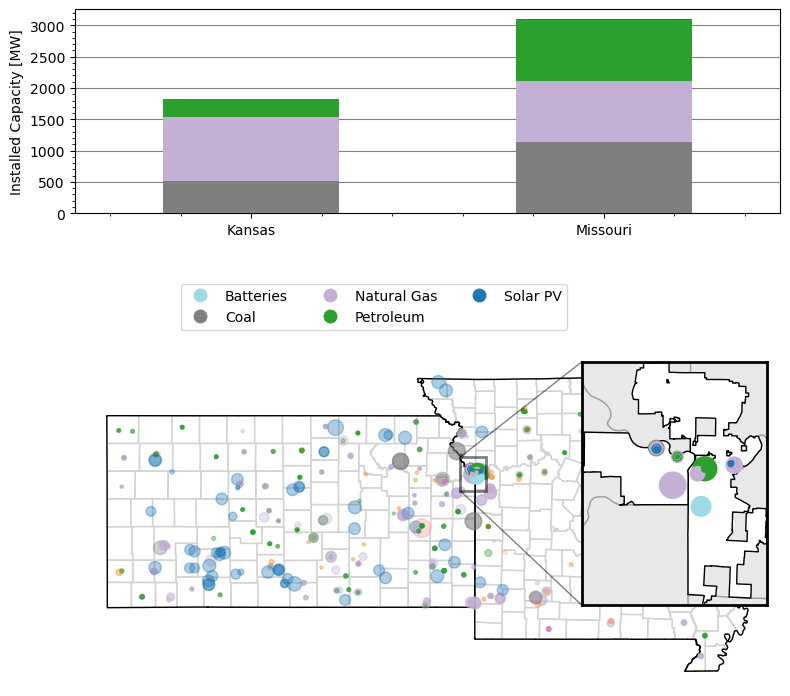

In [38]:
# create axes
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8), 
                       height_ratios=[1,2.5]
                       )

# color map
color_map = 'tab20_r'

# plot kansas and missouri county outlines
ks.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
mo.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
# plot kansas and missouri state outlines
ks.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
mo.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')

# plot all power plants in KS and MO
gdf.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           # legend=True,
                           # legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           alpha=0.2,
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )
# plot all power plants in KC (both sides of river)
kc_plants.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )

# capacity bar plot
kc_plants_pivot.plot(ax=ax[0], kind='bar', 
                 stacked=True, 
                 cmap=color_map,
                 legend=False,
                 zorder=3)

# get inset boundaries
x1,y1,x2,y2 = tuple(kc_outline.to_crs(epsg=4269).total_bounds)

# create inset axes
inset = ax[1].inset_axes([0.65,0.25, 0.4, 0.75],
                         xlim=(x1,x2), ylim=(y1,y2),
                         xticks=[], yticks=[],
                         xticklabels=[], yticklabels=[],)

# change all spines
for axis in ['top','bottom','left','right']:
    inset.spines[axis].set_linewidth(2)

# plot KC on inset
ks.plot(ax=inset, facecolor='lightgray',edgecolor='gray',alpha=0.5, zorder=0)
mo.plot(ax=inset, facecolor='lightgray',edgecolor='gray',alpha=0.5, zorder=0)
kc_ksmo.to_crs(epsg=4269).plot(ax=inset, facecolor='w', edgecolor='k')
# plot KC plants on inset
kc_plants.to_crs(epsg=4269).plot(ax=inset,
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           # legend=True,
                           # legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(np.sqrt)*10
                        )

# show inset
ax[1].indicate_inset_zoom(inset, edgecolor='k', lw=2)

# ax[0].legend(title='')
ax[0].set_xlabel('')
ax[0].tick_params(axis='x',rotation=0)
ax[0].set_ylabel("Installed Capacity [MW]")
ax[1].set_axis_off()
ax[0].minorticks_on()
ax[0].yaxis.grid(which='major',linestyle='-', alpha=0.5, color='k',zorder=0)

plt.tight_layout()

In [39]:
gdf_pivoted

technology,All Other,Batteries,Coal,Hydro,Natural Gas,Nuclear,Petroleum,Solar PV,Wind Turbine
stateName,,,,,,,,,
Kansas,4.0,NaN,9771.2,14.0,9019.2,2535.4,1323.2,80.4,18210.6
Missouri,NaN,2.0,5576.0,32.0,7929.3,NaN,1440.0,148.8,2197.4


In [40]:
buffered_plants_pivot

technology,Batteries,Coal,Hydro,Natural Gas,Petroleum,Solar PV,Wind Turbine
stateName,,,,,,,
Kansas,NaN,1556.0,14.0,2167.2,332.8,4.6,NaN
Missouri,2.0,4588.0,NaN,4224.6,1214.2,49.0,401.8


In [41]:
kc_plants_pivot

technology,Batteries,Coal,Natural Gas,Petroleum,Solar PV
stateName,,,,,
Kansas,NaN,522.0,1017.6,287.2,2.0
Missouri,2.0,1138.0,964.4,980.4,20.0
